*Array_Converter.ipynb* <p style='text-align: right;'> <b> September 20th 2020 </b> </p>
<p style='text-align: right;'> <b> David Diston </b> </p>

# Convert All .mid Files to Numpy Array

***These files will be used when training a model to classify Human Performances and Computer Generated Performances***

This code will sort through each Midi file in the project `Human_Midi` and `Computer_Midi` folders:
1. Each .mid file will be loaded and converted to a numpy array
2. Resulting arrays will have demention (len x 88)
    * Where len = the number of time steps in the piece
    * Where 88 = the number of keys on a standard piano
    * Where each value = the velocity of each note in time (0-127)
3. Each array will be exported and saved to either the `Human_Performance_Array` or `Computer_Performance_Array` folders

In [1]:
# Import the required libraries
import numpy as np
import mido
from mido import MidiFile, MidiTrack, Message, MetaMessage
import matplotlib.pyplot as plt
import os

In [2]:
'''
Due to the difference in note time binning, the transformation from midi file to array will require a slightly
different process for human and computer performance files to ensure that the resulting arrays have the same
amount of musical data per row. Both processes will be detailed below.
'''
human_file_count = 0
computer_file_count = 0

# First: Human conversion
# I will iterate over all files of human performances
for file in os.listdir('HumComp/HumComp_QUANT/Human'):
   
    # I will create a Mido object of each midi file
    clip = MidiFile(f'HumComp/HumComp_QUANT/Human/{file}')

    # This will allow me to find the first note_on message in the midi file
    # Meta data found at the beginning of each midi file will be discarded in this conversion
    for note_msgs, msg in enumerate(clip.tracks[0]):
        if msg.type == 'note_on':
            break

    # I will instantiate an empty list to hold my data
    track_list = []
    # This time_step list will temporarily hold each binned time step of note data for each
    # of the 88 notes of the piano
    time_step = [0] * 88
    
    # I will iterate over every note message in the midi file (starting after the meta data)
    '''
    For each note message with a time step of zero, the velocity of that note will be recorded in the 
    current time_step list at the index of that particular note value. Once a new time bin has been reached
    the current contents of the time_step list will be appended to the track_list, and a blank (all zero)
    time_step list will be instantiated.
    '''
    for msg in clip.tracks[0][note_msgs:]:
        # If the new time bin starts with a non-note message, the current time_step will be appended
        # and a blank time_step will be instantiated
        if (msg.type != 'note_on') and (msg.type != 'note_off') and (msg.time > 0):  
            track_list.append(time_step)
            time_step = [0] * 88
        # If the new time bin starts with a note message, the current time_step will be appended to
        # the track list, and a new time_step will be instantiated
        # This note will then be inserted into the newly instantiated time_step list
        elif (msg.type == 'note_on' or msg.type == 'note_off') and (msg.time > 0):
            track_list.append(time_step)
            time_step = [0] *88
            # Note will convert the midi note value, to the actual piano key value
            note = (msg.note - 21)
            # This note velocity will be input into the time_step list at the index of the note number
            time_step[note] = msg.velocity
        # If the message is a note message, and the time step is zero, this note velocity will be
        # input into the time_step list at the index of the note number
        elif (msg.type == 'note_on' or msg.type == 'note_off') and (msg.time == 0):
            note = (msg.note - 21)
            time_step[note] = msg.velocity

    # Here I will append any final partial bin of note values to the track list
    if sum(time_step) > 0:
        track_list.append(time_step)
    else:
        pass

    # Here I will convert my track list to a numpy array
    track_array = np.array(track_list)
    # The file name will be the same but with a new file extention
    name = file[: -4] + '.npy'
    # I will save the new array
    np.save(f'HumComp/HumComp_Array/Human/{name}', track_array)
    
    # This will output a progress note
    human_file_count += 1    
    print(f'Processed {human_file_count} human performance arrays.', end = '\r')

# The conversion of computer files is the same as above, with one alteration
for file in os.listdir('HumComp/HumComp_QUANT/Computer/'):
   
    # I will create a Mido object of each midi file
    clip = MidiFile(f'HumComp/HumComp_QUANT/Computer/{file}')

    # This will allow me to find the first note_on message in the midi file
    # Meta data found at the beginning of each midi file will be discarded in this conversion
    for note_msgs, msg in enumerate(clip.tracks[0]):
        if msg.type == 'note_on':
            break

    track_list = []
    time_step = [0] * 88
    
    # I will iterate over every note message in the midi file (starting after the meta data)
    '''
    For each note message with a time step of zero, the velocity of that note will be recorded in the 
    current time_step list at the index of that particular note value. Once a new time bin has been reached
    the current contents of the time_step list will be appended to the track_list, and a blank (all zero)
    time_step list will be instantiated.
    '''
    # Here I will identify only where this process differs from above
    for msg in clip.tracks[0][note_msgs:]:
        if (msg.type != 'note_on') and (msg.type != 'note_off') and (msg.time > 0):  
            track_list.append(time_step)
            time_step = [0] * 88
            '''
            Since computer midi files were quantized to the nearest 16th note, and human files quantized
            to the nearest 32nd note, the data density in human files is twice that of the computer files.
            To ensure that the resulting arrays have the same length of musical for 'n' rows of data, and to not
            introduce bias with different data densities between the classes, after each time_step list
            that is appended to the track list, a blank (all zero) time_step will also be appended. This
            will ensure that an array of 'n' length selected from the computer performance array, and human
            performance array of the same piece will contain the same length of music
            '''
            track_list.append(time_step)
        elif (msg.type == 'note_on' or msg.type == 'note_off') and (msg.time > 0):
            track_list.append(time_step)
            time_step = [0] *88
            # Once again, a blank time_step is appended to equalize the data density
            track_list.append(time_step)
            note = (msg.note - 21)
            time_step[note] = msg.velocity
        elif (msg.type == 'note_on' or msg.type == 'note_off') and (msg.time == 0):
            note = (msg.note - 21)
            time_step[note] = msg.velocity

    # Again, any remaining partial bin is appended to the track list
    if sum(time_step) > 0:
        track_list.append(time_step)
    else:
        pass

    # The track list is converted to a numpy array
    track_array = np.array(track_list)
    name = file[: -4] + '.npy'
    np.save(f'HumComp/HumComp_Array/Computer/{name}', track_array)
    
    computer_file_count += 1    
    print(f'Processed {computer_file_count} computer performance arrays.', end = '\r')
    
    
print('\nDone')

Processed 2583 computer performance arrays.
Done


#### Visualization of Array
Below is a visualization example of the arrays I have created. The 88 notes of the standard piano are arranged along the y-axis, while the x-axis is a representation of the length of the piece in quantizations (dependent on the quantization of the original midi file). This visualization clearly shows the note distribution over the length of a piece.

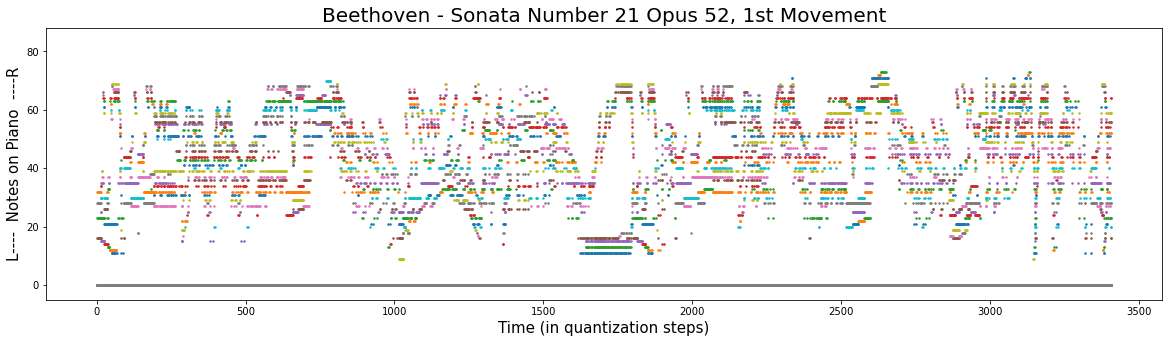

In [3]:
# I chose this file to visualize, since it is longer and contains more information to show in a plot
clip = MidiFile('HumComp/HumComp_QUANT/Human/PF--AllisonTo_N--USA_C--Beethoven_T--SonataNo21Op521stMov.MID')

# Rather than find the particular array for this file created above, I quickly recreated the array below
# based on the above method
for note_msgs, msg in enumerate(clip.tracks[0]):
    if msg.type == 'note_on':
        break

track_list = []
time_step = [0] * 88
for msg in clip.tracks[0][note_msgs:]:
    if (msg.type != 'note_on') and (msg.type != 'note_off') and (msg.time > 0):  
        track_list.append(time_step)
        time_step = [0] * 88
    elif (msg.type == 'note_on' or msg.type == 'note_off') and (msg.time > 0):
        track_list.append(time_step)
        time_step = [0] *88
        note = (msg.note - 21)
        time_step[note] = msg.velocity
    elif (msg.type == 'note_on' or msg.type == 'note_off') and (msg.time == 0):
        note = (msg.note - 21)
        time_step[note] = msg.velocity

if sum(time_step) > 0:
    track_list.append(time_step)
else:
    pass

# Convert the track list created above into an array
example = np.array(track_list)

# Using matplotlib I plot the resulting array
plt.figure(figsize = (20,5))
# In addition to each note, I will plot the length of the piece as a visual line
plt.plot(range(example.shape[0]), np.multiply(np.where(example>0, 1, 0), range(1, 89)), marker='.', markersize=3, linestyle='')
plt.title('Beethoven - Sonata Number 21 Opus 52, 1st Movement', fontsize = 20)
plt.ylabel('L----  Notes on Piano  ----R', fontsize = 15)
plt.xlabel('Time (in quantization steps)', fontsize = 15)
plt.ylim(-5, 88)
plt.show()

This visualization can be interpreted similarly to a piano-reel. The 88 keys of a piano are listed along the y-axis (L for left hand `Bass` and R for right hand `Treble`). The length of the piece is along the x-axis. Looking left to right along the visual, each note of the piece is shown by a point in the graph at the time it is played. This visual shows the note distribution over time, specifically the note density, and generally the pitch centre (high pitch, low pitch, or medium pitch) throughout the piece. Specifics can also be observed, for example at around the 1600 time step there is a clear ostinato in the bass range with a higher treble run in the right hand at the same time.

<p style='text-align: right;'> <b> Next Step: </b> Split the Data into Train and Test Sets - <em> 06-Test_Set_Split.ipynb </em> </p>